<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NYC-Housing-Data-2003-2019" data-toc-modified-id="NYC-Housing-Data-2003-2019-1">NYC Housing Data 2003-2019</a></span><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1.1">Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Постановка-бизнес-задачи" data-toc-modified-id="Постановка-бизнес-задачи-1.1.1">Постановка бизнес задачи</a></span></li><li><span><a href="#Математическая-постановки-задачи" data-toc-modified-id="Математическая-постановки-задачи-1.1.2">Математическая постановки задачи</a></span></li></ul></li><li><span><a href="#Загрузка-библиотек-и-настроек" data-toc-modified-id="Загрузка-библиотек-и-настроек-1.2">Загрузка библиотек и настроек</a></span></li><li><span><a href="#Загрузка-данных-и-предпоказ" data-toc-modified-id="Загрузка-данных-и-предпоказ-1.3">Загрузка данных и предпоказ</a></span></li><li><span><a href="#Profiling" data-toc-modified-id="Profiling-1.4">Profiling</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1.5">Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Удаление-дубликатов" data-toc-modified-id="Удаление-дубликатов-1.5.1">Удаление дубликатов</a></span></li><li><span><a href="#Создание-отложенной-выборки-для-оценки-экономической-выгоды" data-toc-modified-id="Создание-отложенной-выборки-для-оценки-экономической-выгоды-1.5.2">Создание отложенной выборки для оценки экономической выгоды</a></span></li><li><span><a href="#Выделение-категориальных-и-числовых-признаков" data-toc-modified-id="Выделение-категориальных-и-числовых-признаков-1.5.3">Выделение категориальных и числовых признаков</a></span></li><li><span><a href="#Анализ-числовых-переменных" data-toc-modified-id="Анализ-числовых-переменных-1.5.4">Анализ числовых переменных</a></span></li><li><span><a href="#Обработка-пропусков" data-toc-modified-id="Обработка-пропусков-1.5.5">Обработка пропусков</a></span></li><li><span><a href="#Анализ-категориальных-переменных" data-toc-modified-id="Анализ-категориальных-переменных-1.5.6">Анализ категориальных переменных</a></span></li><li><span><a href="#Выделение-года-продажи" data-toc-modified-id="Выделение-года-продажи-1.5.7">Выделение года продажи</a></span></li><li><span><a href="#Дамп-категорий" data-toc-modified-id="Дамп-категорий-1.5.8">Дамп категорий</a></span></li></ul></li><li><span><a href="#Анализ-целевого-признака" data-toc-modified-id="Анализ-целевого-признака-1.6">Анализ целевого признака</a></span></li><li><span><a href="#Разработка-модели" data-toc-modified-id="Разработка-модели-1.7">Разработка модели</a></span><ul class="toc-item"><li><span><a href="#Разбитие-на-выборки" data-toc-modified-id="Разбитие-на-выборки-1.7.1">Разбитие на выборки</a></span><ul class="toc-item"><li><span><a href="#Features-&amp;-Target" data-toc-modified-id="Features-&amp;-Target-1.7.1.1">Features &amp; Target</a></span></li><li><span><a href="#Train-&amp;-Test" data-toc-modified-id="Train-&amp;-Test-1.7.1.2">Train &amp; Test</a></span></li></ul></li><li><span><a href="#Подбор-гипперпараметров-модели" data-toc-modified-id="Подбор-гипперпараметров-модели-1.7.2">Подбор гипперпараметров модели</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-1.8">Тестирование модели</a></span></li><li><span><a href="#Анализ-модели" data-toc-modified-id="Анализ-модели-1.9">Анализ модели</a></span><ul class="toc-item"><li><span><a href="#Feature-importances" data-toc-modified-id="Feature-importances-1.9.1">Feature importances</a></span></li><li><span><a href="#Стабильность-работы" data-toc-modified-id="Стабильность-работы-1.9.2">Стабильность работы</a></span></li><li><span><a href="#Скорость-деградации" data-toc-modified-id="Скорость-деградации-1.9.3">Скорость деградации</a></span></li></ul></li><li><span><a href="#Сравнение-результатов-с-baseline" data-toc-modified-id="Сравнение-результатов-с-baseline-1.10">Сравнение результатов с baseline</a></span></li><li><span><a href="#Дамп-модели" data-toc-modified-id="Дамп-модели-1.11">Дамп модели</a></span></li><li><span><a href="#Оценка-экономического-эффекта" data-toc-modified-id="Оценка-экономического-эффекта-1.12">Оценка экономического эффекта</a></span><ul class="toc-item"><li><span><a href="#Для-обученной-модели:" data-toc-modified-id="Для-обученной-модели:-1.12.1">Для обученной модели:</a></span></li><li><span><a href="#Для-baseline-модели:" data-toc-modified-id="Для-baseline-модели:-1.12.2">Для baseline модели:</a></span></li><li><span><a href="#Зависимость-оценки-эффекта-от-качества-модели" data-toc-modified-id="Зависимость-оценки-эффекта-от-качества-модели-1.12.3">Зависимость оценки эффекта от качества модели</a></span></li></ul></li></ul></li></ul></div>

# NYC Housing Data 2003-2019

## Описание проекта

Набор данных содержит информацию о ценах на жилье в Нью-Йорке на основе данных за последние 17 лет. Данные из открытых источников Департамента финансов Нью-Йорка.

### Постановка бизнес задачи

Допустим у нас есть платформа, которая является базой объявлений об аренде и продаже недвижимости. Одним из вариантов получения прибыли является риелторская коммиссия с суммы продажи или аренды. В этом случае целесообразно разработать модель, которая сможет определить рыночную стоимость продажи или аренды интересующей недвижимости. Определение стоимости защитит платформу и ее пользователей от недобросовестных клиентов, которые заинтересованы в занижении или завышении цены. Предсказание стоимости само по себе также можно использовать как коммерческую услугу.

### Математическая постановки задачи

Такая бизнес-цель требует построения модели регрессионного анализа. Так как цены на жилье меняются из года в год, для построения поддержания работоспособности модели необходимо обучать ее на актульных данных. Оптимальной метрикой качества для данной задачи, на мой взгляд, является RMSE, стремящееся к нулю. Для интерпретации результатов работы модели воспользуемся метрикой MAE.

## Загрузка библиотек и настроек

In [1]:
import os
import re
import time
import json
import joblib
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, Math, Markdown

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.dummy import DummyRegressor

from pandas_profiling import ProfileReport

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style='whitegrid')
plt.rcParams["figure.figsize"] = (18,7)
plt.rcParams["figure.dpi"] = 80
plt.rcParams["figure.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

## Загрузка данных и предпоказ

In [4]:
path = r'e:\Documents\datasets\mtc\NYC Housing Data 2003-2019'

file_name = 'data.csv'
profiling_title = 'Profiling NYC Housing Data 2003-2019'
try:
    os.makedirs(os.path.join(path, profiling_title))
    df = pd.read_csv(os.path.join(path, file_name), parse_dates=['SALE DATE'])
except:
    df = pd.read_csv(os.path.join(path, file_name), parse_dates=['SALE DATE'])

In [5]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,02 TWO FAMILY HOMES,746 EAST 6 STREET,10009.0,2134.0,3542.0,1899.0,1800000,2003-01-22
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,316 EAST 3 STREET,10009.0,5746.0,2700.0,1900.0,0,2003-12-18
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,316 EAST 3 STREET,10009.0,5746.0,2700.0,1900.0,0,2003-12-18
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,125 AVENUE D,10009.0,2185.0,5725.0,1910.0,426000,2003-10-23
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,610 EAST 9 STREET,10009.0,2543.0,11568.0,1910.0,0,2003-02-28


## Profiling

In [6]:
#profile = ProfileReport(df, title='Orig ' + profiling_title)
#profile.to_file(output_file=os.path.join(path, profiling_title, "profiling_report.html"))

In [7]:
#profile = ProfileReport(df, title='Edit ' + profiling_title)
#profile.to_file(output_file=os.path.join(path, profiling_title, "profiling_report_edit.html"))

## Предобработка данных

In [8]:
display(Markdown(f'В таблице строк: `{df.shape[0]:,.0f}`, столбцов: `{df.shape[1]}`'))

В таблице строк: `1,600,202`, столбцов: `10`

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600202 entries, 0 to 1600201
Data columns (total 10 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   BOROUGH                  1600202 non-null  int64         
 1   NEIGHBORHOOD             1600202 non-null  object        
 2   BUILDING CLASS CATEGORY  1600202 non-null  object        
 3   ADDRESS                  1600202 non-null  object        
 4   ZIP CODE                 1600186 non-null  float64       
 5   LAND SQUARE FEET         1582975 non-null  float64       
 6   GROSS SQUARE FEET        1582976 non-null  float64       
 7   YEAR BUILT               1594175 non-null  float64       
 8   SALE PRICE               1600202 non-null  int64         
 9   SALE DATE                1600202 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 122.1+ MB


### Удаление дубликатов

In [10]:
df.drop_duplicates(inplace=True, ignore_index=True)

### Создание отложенной выборки для оценки экономической выгоды

In [11]:
df, df_test = train_test_split(df, test_size=10000, random_state=12345)

### Выделение категориальных и числовых признаков

In [12]:
category_columns = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'ZIP CODE']
string_columns = ['ADDRESS']
numeric_columns = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE']

In [13]:
#df = df.reset_index(drop=True)
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ADDRESS,ZIP CODE,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
647963,4,SO. JAMAICA-BAISLEY PARK,01 ONE FAMILY HOMES,150-26 116TH ROAD,11434.0,2000.0,831.0,1925.0,465000,2008-11-06
584227,1,MIDTOWN WEST,25 LUXURY HOTELS,102 WEST 57TH STREET,10019.0,7532.0,112850.0,2007.0,92405,2008-06-20
1215448,1,UPPER WEST SIDE (59-79),10 COOPS - ELEVATOR APARTMENTS,"11 RIVERSIDE DRIVE, 3NE",10023.0,0.0,0.0,1950.0,2175000,2016-12-13
1055031,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,8209 6TH AVENUE,11209.0,1771.0,2040.0,1920.0,765000,2014-12-01
1449568,5,NEW DORP,02 TWO FAMILY DWELLINGS,62 BACHE AVENUE,10306.0,4000.0,2100.0,1925.0,0,2018-11-16
...,...,...,...,...,...,...,...,...,...,...
1134974,2,COUNTRY CLUB,01 ONE FAMILY DWELLINGS,1044 DEAN AVENUE,10465.0,2773.0,1998.0,1960.0,267000,2015-04-13
896425,3,BOROUGH PARK,03 THREE FAMILY HOMES,1366 45TH STREET,11219.0,2204.0,5544.0,1985.0,0,2012-12-20
1396132,3,BAY RIDGE,02 TWO FAMILY DWELLINGS,101 72ND STREET,11209.0,2000.0,3000.0,1925.0,0,2018-12-12
1443969,4,WHITESTONE,01 ONE FAMILY DWELLINGS,145-05 15TH AVENUE,11357.0,5580.0,2023.0,0.0,845000,2018-04-13


### Анализ числовых переменных

In [14]:
def boxplots_numeric(df=df):
    fig = plt.figure()
    fig.suptitle(f'Распределение числовых переменных'.upper(), position=(0.5,0.98), weight='demibold')
    for i, col in enumerate(numeric_columns, start=1):
        plt.subplot(2,2,i)
        sns.boxplot(df[col], orient='h', width=0.5)#
        sns.despine(top=True, right=True, left=True, bottom=True, trim=False)
        plt.ylabel('')
        plt.xlabel('')
        plt.grid(True, axis='x', linestyle=':', linewidth=2)
        plt.tick_params(direction='in', length=0)
        plt.title(f'{col}', pad=0, ha='center', va='top', position=(0.5,0))

In [15]:
def hist_numeric(df=df):
    fig = plt.figure()
    fig.suptitle(f'Распределение числовых переменных'.upper(), position=(0.5,0.98), weight='demibold')
    for i, col in enumerate(numeric_columns, start=1):
        plt.subplot(2,2,i)
        sns.histplot(df[col], stat='density', kde=False, bins=50)#
        sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
        plt.ylabel('')
        plt.xlabel('')
        plt.grid(True, axis='both', linestyle=':', linewidth=2)
        plt.tick_params(direction='in', length=0)
        plt.title(f'{col}', pad=0, ha='center', va='bottom', position=(0.5,0))#

In [16]:
def drop_outliers(series, n_of_iqr=2):
    q75, q25 = np.nanpercentile(series,(75,25))
    iqr = q75 - q25

    max_value = q75 + (n_of_iqr * iqr)
    min_value = q25 - (n_of_iqr * iqr)

    series.loc[series < min_value] = np.nan
    series.loc[series > max_value] = np.nan

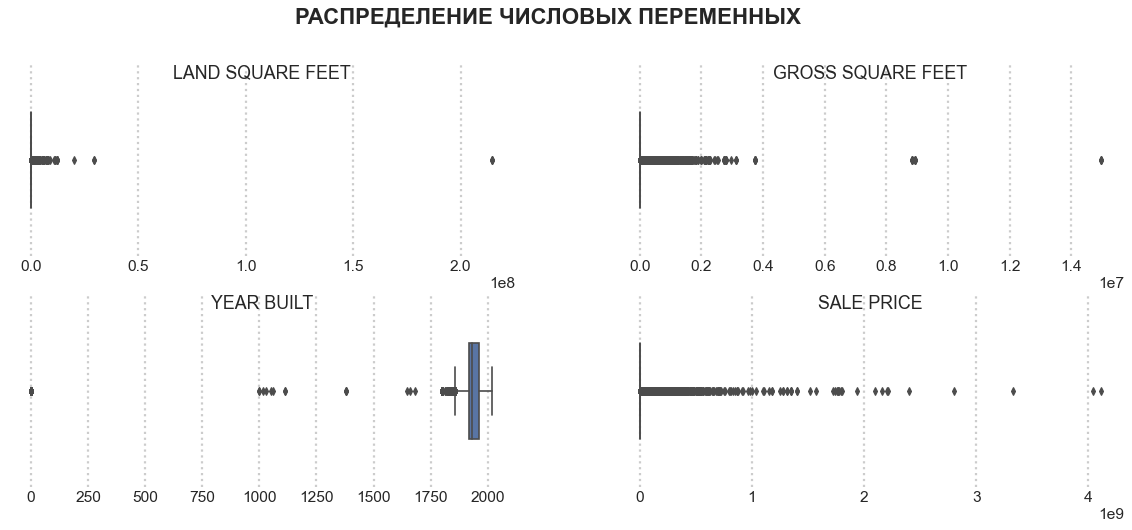

In [17]:
boxplots_numeric()

In [18]:
df.loc[:,'LAND SQUARE FEET'].mask(df.loc[:,'LAND SQUARE FEET'] < 50, inplace=True)
df.loc[:,'GROSS SQUARE FEET'].mask(df.loc[:,'GROSS SQUARE FEET'] < 50, inplace=True)
df.loc[:,'YEAR BUILT'].mask(df.loc[:,'YEAR BUILT'] < 1600, inplace=True)
df.loc[:,'SALE PRICE'].mask(df.loc[:,'SALE PRICE'] < 1e3, inplace=True)
df.dropna(how='any', inplace=True)

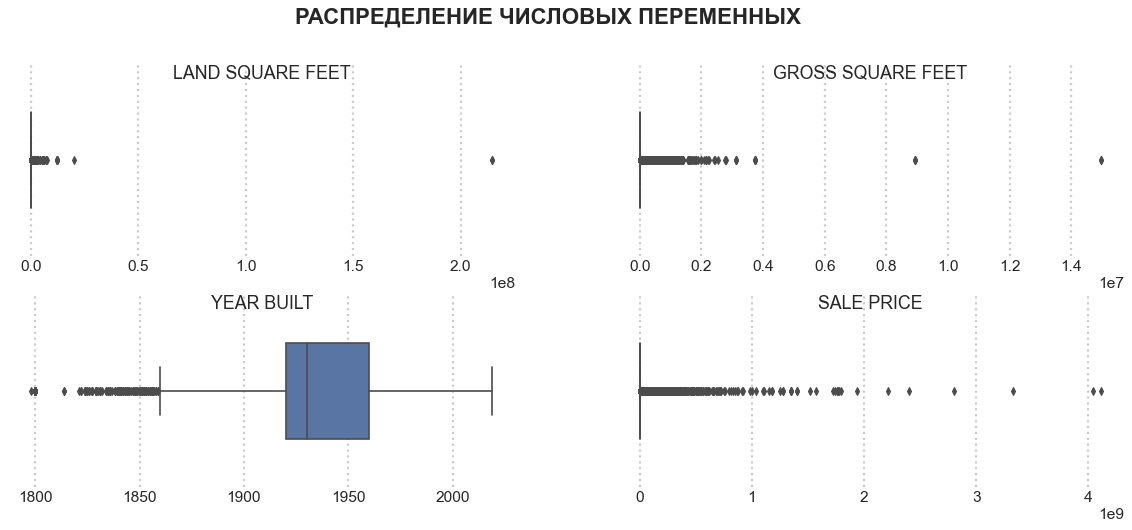

In [19]:
boxplots_numeric()

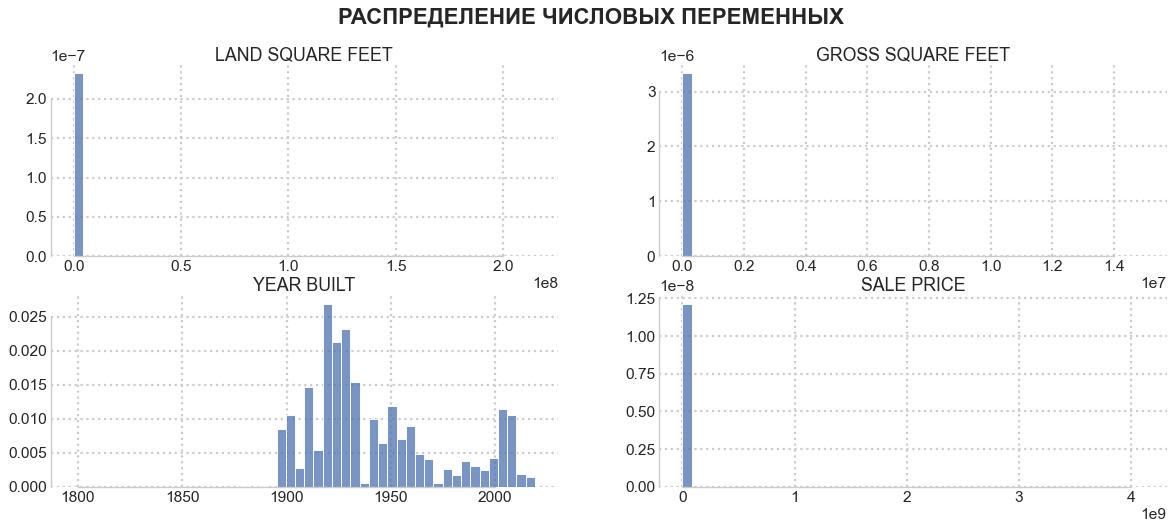

In [20]:
hist_numeric()

In [21]:
for column in numeric_columns:
    drop_outliers(df.loc[:, column])

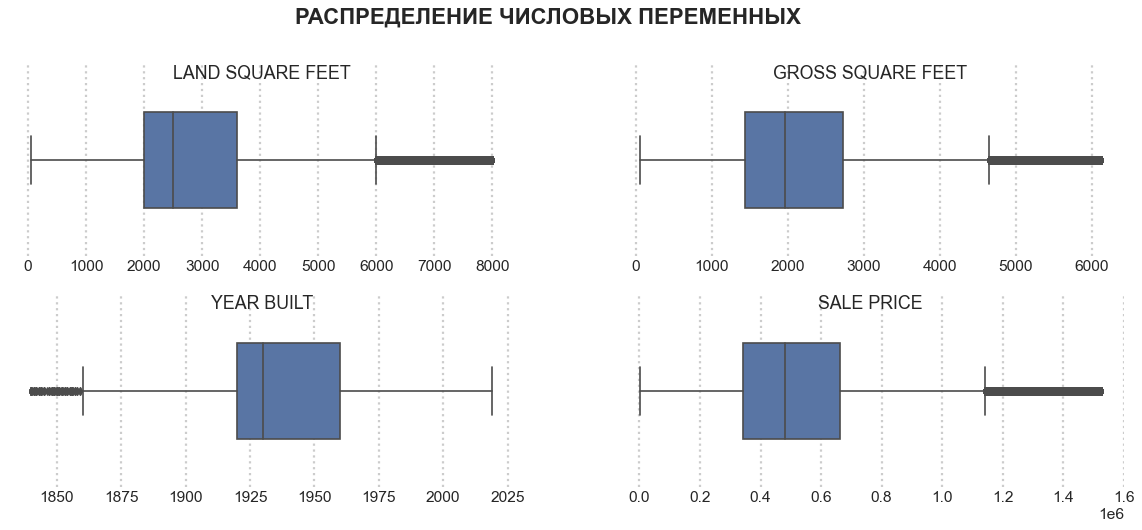

In [22]:
boxplots_numeric()

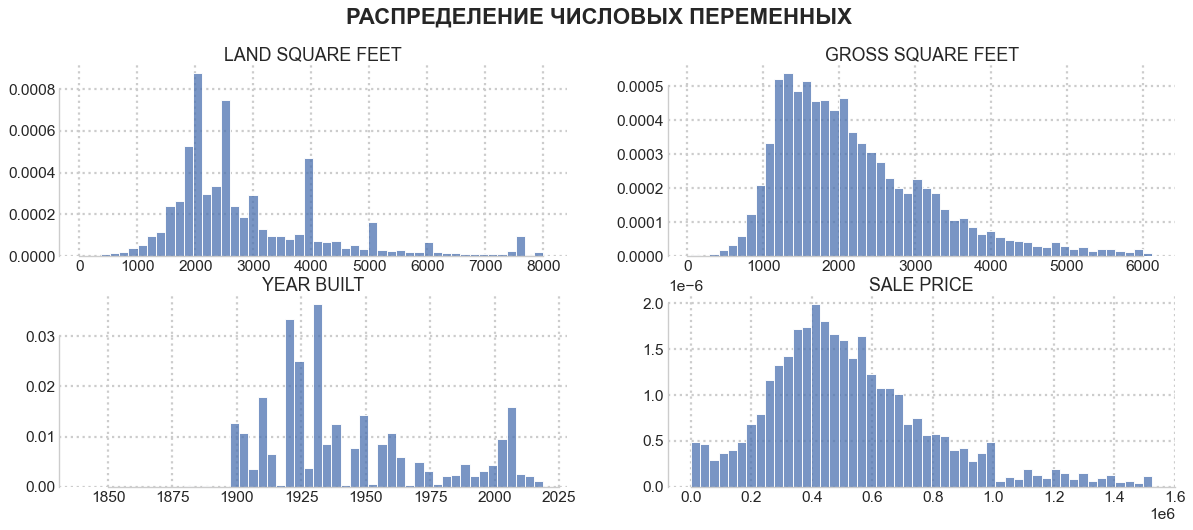

In [23]:
hist_numeric()

### Обработка пропусков

In [24]:
def typeing_features(df, category_columns=category_columns, numeric_columns=numeric_columns, str_cols=string_columns):
    df.dropna(how='any', inplace=True)
    df.loc[:, category_columns] = df.loc[:, category_columns].astype('object')
    df.loc[:, str_cols] = df.loc[:, str_cols].astype('string')
    df.loc[:, numeric_columns] = df.loc[:, numeric_columns].astype('int64')

In [25]:
def feature_editing_1(df):
    df['BOROUGH'] = df['BOROUGH'].apply(lambda x: str(x))
    df['ZIP CODE'] = df['ZIP CODE'].apply(lambda x: None if len(str(x)) != 7 else str(x))
    df.dropna(how='any', inplace=True)
    df['ZIP CODE'] = df['ZIP CODE'].apply(lambda x: str(x).split('.')[0])

In [26]:
df.isna().sum()

BOROUGH                        0
NEIGHBORHOOD                   0
BUILDING CLASS CATEGORY        0
ADDRESS                        0
ZIP CODE                       0
LAND SQUARE FEET           25499
GROSS SQUARE FEET          42603
YEAR BUILT                   124
SALE PRICE                 45150
SALE DATE                      0
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540628 entries, 647963 to 1134974
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   BOROUGH                  540628 non-null  int64         
 1   NEIGHBORHOOD             540628 non-null  object        
 2   BUILDING CLASS CATEGORY  540628 non-null  object        
 3   ADDRESS                  540628 non-null  object        
 4   ZIP CODE                 540628 non-null  float64       
 5   LAND SQUARE FEET         515129 non-null  float64       
 6   GROSS SQUARE FEET        498025 non-null  float64       
 7   YEAR BUILT               540504 non-null  float64       
 8   SALE PRICE               495478 non-null  float64       
 9   SALE DATE                540628 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 45.4+ MB


In [28]:
typeing_features(df)
feature_editing_1(df)

In [29]:
display(Markdown(f'Количество пропущенных значений в таблице: `{df.isna().sum().sum()}`'))
display(Markdown(f'Не пустых строк: `{df.shape[0]:,.0f}`, столбцов: `{df.shape[1]}`'))

Количество пропущенных значений в таблице: `0`

Не пустых строк: `467,814`, столбцов: `10`

### Анализ категориальных переменных

In [30]:
def del_whitespace_1(x):
    new_x=[]
    for i in x.split(' ')[1:]:
        if len(i) > 0:
            new_x.append(i)
    return ' '.join(new_x)

In [31]:
def del_whitespace_2(x):
    new_x=[]
    for i in x.split(' '):
        if len(i) > 0:
            new_x.append(i)
    return ' '.join(new_x)

In [32]:
def feature_editing_2(df, category_columns=category_columns + string_columns):
    df[category_columns] = df[category_columns].apply(lambda x: x.apply(lambda x: x.strip().upper()))

    df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].apply(del_whitespace_1).str.replace('/',' ')
    df['NEIGHBORHOOD'] = df['NEIGHBORHOOD'].str.replace('-',' ').str.replace('/',' ').str.replace('.',' ').apply(del_whitespace_2)
    df['ADDRESS'] = df['ADDRESS'].apply(del_whitespace_2).str.replace('-',' ')#.apply(del_whitespace_1)

In [33]:
df[category_columns + string_columns].describe().loc['unique',:].to_frame()

,unique
BOROUGH,5
NEIGHBORHOOD,485
BUILDING CLASS CATEGORY,78
ZIP CODE,177
ADDRESS,380883


In [34]:
feature_editing_2(df)

In [35]:
df.drop_duplicates(inplace=True)#, ignore_index=True

In [36]:
df[category_columns + string_columns].describe().loc['unique',:].to_frame()

,unique
BOROUGH,5
NEIGHBORHOOD,250
BUILDING CLASS CATEGORY,38
ZIP CODE,177
ADDRESS,351367


### Выделение года продажи

In [37]:
def extruct_year(df):
    df['SALE DATE YEAR'] = df['SALE DATE'].dt.year

In [38]:
def typeing_features_2(df, category_columns=category_columns, numeric_columns=numeric_columns):
    df[numeric_columns] = df[numeric_columns].astype('int64')
    df[category_columns] = df[category_columns].astype('category')

In [39]:
extruct_year(df)
typeing_features_2(df)

### Дамп категорий

In [40]:
cat_dict = dict()
for col in category_columns:
    cat_dict[col] = df[col].cat.categories.to_list()

#with open("category_dictionary.json", "w") as fp:
#    json.dump(cat_dict , fp)

In [41]:
#df.loc[:,['BOROUGH', 'NEIGHBORHOOD', 'ZIP CODE']].drop_duplicates(ignore_index=True).to_csv("category_intersections.csv", index=False)

## Анализ целевого признака

In [42]:
mean_price_per_year_series = df.groupby('SALE DATE YEAR')['SALE PRICE'].mean()

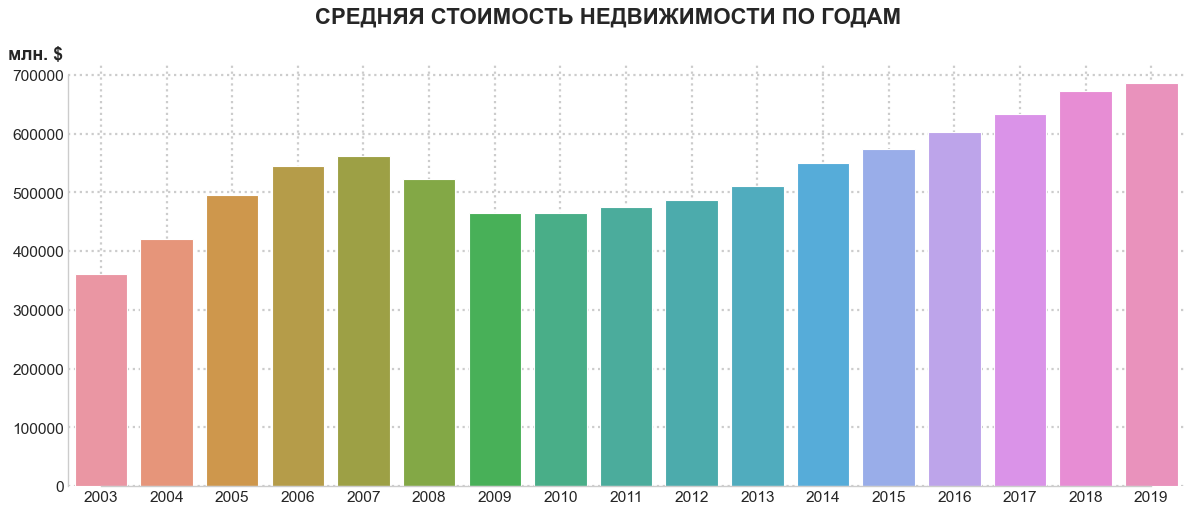

In [43]:
fig = plt.figure()
fig.suptitle(f'Средняя стоимость недвижимости по годам'.upper(), position=(0.5,0.98), weight='demibold')
sns.barplot(x=mean_price_per_year_series.index, y=mean_price_per_year_series)#
sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
plt.ylabel('млн. $', ha='left', va='bottom', weight='semibold', rotation='horizontal', position=(0,1))
plt.xlabel('')
plt.grid(True, axis='both', linestyle=':', linewidth=2)
plt.tick_params(direction='in', length=0)

In [44]:
newest_df = df[df['SALE DATE YEAR'] > 2017].reset_index(drop=True).copy()
display(Markdown(f'В отобранном датасете строк: `{newest_df.shape[0]:,.0f}`, столбцов: `{newest_df.shape[1]}`'))

В отобранном датасете строк: `48,150`, столбцов: `11`

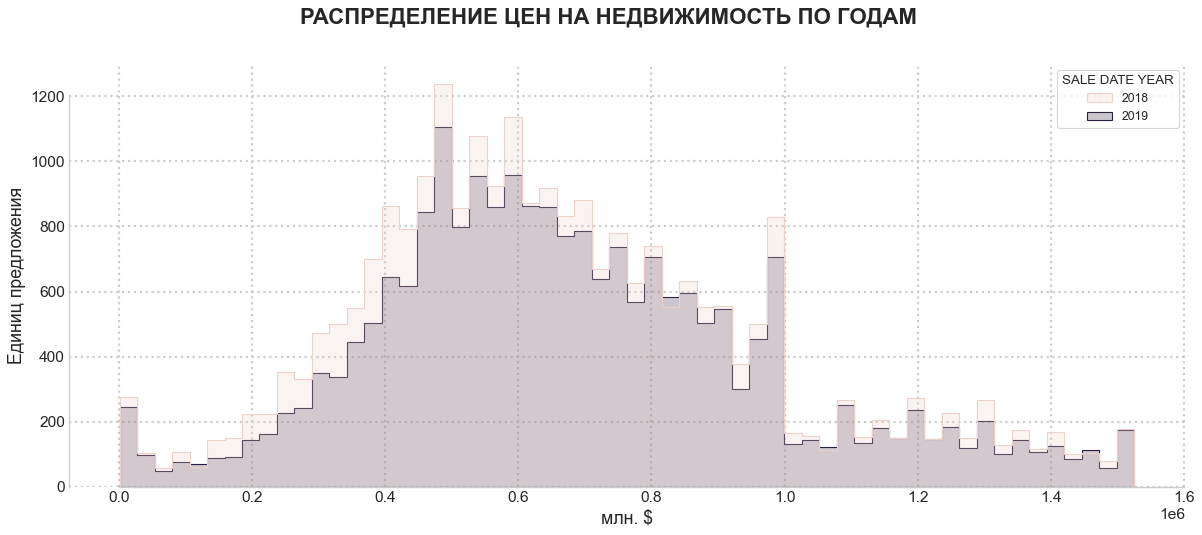

In [45]:
sns.color_palette()
fig = plt.figure()
fig.suptitle(f'Распределение цен на недвижимость по годам'.upper(), position=(0.5,0.98), weight='demibold')
sns.histplot(data=newest_df, x='SALE PRICE', hue='SALE DATE YEAR', kde=False, common_bins=False, element="step")#
sns.despine(top=True, right=True, left=False, bottom=False, trim=True)
plt.ylabel('Единиц предложения')
plt.xlabel('млн. $')
plt.grid(True, axis='both', linestyle=':', linewidth=2)
plt.tick_params(direction='in', length=0)

## Разработка модели

### Разбитие на выборки

#### Features & Target

In [46]:
drop_columns=['SALE PRICE', 'BOROUGH', 'ADDRESS', 'SALE DATE', 'SALE DATE YEAR']#
features_columns = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'ZIP CODE',
                    'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']
features = newest_df[features_columns]
target = newest_df['SALE PRICE']

#### Train & Test

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

### Подбор гипперпараметров модели

In [48]:
cat_features = X_train.select_dtypes('category').columns.to_list()

In [49]:
best_score = 1e9
iterations, learning_r = 0, 0
start_time = time.time()

for i in np.arange(251, 255, 1):
    for j in np.arange(0.85, 0.88, 0.01):
        model = CatBoostRegressor(iterations=i,
                                  learning_rate=j,
                                  max_depth=3,
                                  cat_features=cat_features,
                                  verbose=False,
                                  random_state=12345,
                                  loss_function='RMSE',
                                 )

        n_scores = cross_val_score(model,
                                   X_train,
                                   y_train,
                                   scoring='neg_root_mean_squared_error',
                                   cv=5,
                                   n_jobs=-1,
                                   error_score='raise'
                                  )

        score = np.mean(np.abs(n_scores))

        if score < best_score:
            best_score = score
            best_n_scores = n_scores
            iterations = i
            learning_r = j

fit_time = time.time() - start_time

display(HTML(f'<b>Гипперпараметры iterations:</b> <code>{iterations}</code>, <b>learning_rate:</b> <code>{learning_r:,.3f}</code>'))
display(HTML(f'<b>Лучшее RMSE: </b> <code>{best_score:,.1f}</code>'))
display(HTML(f'<b>Время обучения: </b> <code>{fit_time:,.2f}</code> c'))

## Тестирование модели

In [50]:
model = CatBoostRegressor(iterations=iterations,
                          learning_rate=learning_r,
                          max_depth=3,
                          cat_features=cat_features,
                          verbose=False,
                          random_state=12345,
                         )
model.fit(X_train, y_train)
score_rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)
score_mae = mean_absolute_error(y_test, model.predict(X_test))

display(Markdown(f'**RMSE на тестовой выборке:** `{score_rmse:,.1f}`'))
display(Markdown(f'**MAE на тестовой выборке:** `{score_mae:,.1f}`'))

**RMSE на тестовой выборке:** `213,406.2`

**MAE на тестовой выборке:** `146,739.6`

## Анализ модели

### Feature importances

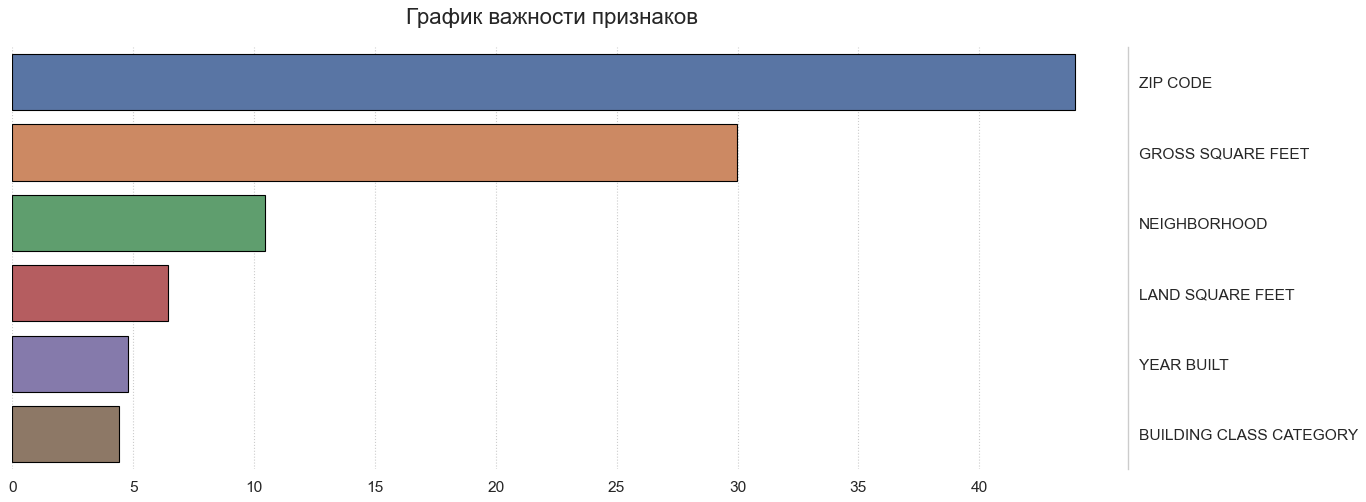

In [51]:
fi = pd.DataFrame({'feature_importances':model.feature_importances_}, index=features.columns).sort_values(by='feature_importances', ascending=False)

fig = plt.figure()
fig.suptitle(f'График важности признаков', x=.5, y=.95)
sns.barplot(data=fi, x='feature_importances', y=fi.index, linewidth=1, edgecolor='black')
sns.despine(top=True, right=False, left=True, bottom=True, trim=False)
plt.grid(True, axis='x', linestyle=':', linewidth=1)
plt.tick_params(axis='both', direction='out', length=6, width=1)
plt.ylabel('')
plt.xlabel('')
plt.xticks(list(range(0,45,5)))
plt.show()

### Стабильность работы

In [52]:
for fold in [f'**{n}-fold:** `{x:,.1f}`' for n,x in enumerate(best_n_scores, start=1)]:
    display(Markdown(fold))

**1-fold:** `-216,378.1`

**2-fold:** `-214,467.7`

**3-fold:** `-209,398.6`

**4-fold:** `-210,555.4`

**5-fold:** `-216,740.4`

Видно, что модель показывает себя достаточно стабильно при работе на разных фолдах.

### Скорость деградации 

Модель обучена на срезе данных, взятых за последние 2 года (2018 и 2019 года). Поэтому рекомендуется производить переобучение модели периодичностью раз в год, при кратном изменении цен на рынке в целом - в кратчайший срок.

## Сравнение результатов с baseline

In [53]:
def baseline_prediction(df, X):
    return df.loc[X.index,:].groupby(['BOROUGH','ZIP CODE','SALE DATE YEAR'])['SALE PRICE'].transform('mean')

In [54]:
dummy_prediction = baseline_prediction(newest_df, X_test)

score_rmse_baseline = mean_squared_error(y_test, dummy_prediction, squared=False)
score_mae_baseline = mean_absolute_error(y_test, dummy_prediction)

display(Markdown(f'**RMSE для baseline модели на тестовой выборке:** `{score_rmse_baseline:,.1f}`'))
display(Markdown(f'**MAE для baseline на тестовой выборке:** `{score_mae_baseline:,.1f}`'))

**RMSE для baseline модели на тестовой выборке:** `240,492.8`

**MAE для baseline на тестовой выборке:** `180,153.3`

## Дамп модели

In [55]:
#with open('regressor_model.pkl', 'wb') as output:
#    joblib.dump(model, output)

## Оценка экономического эффекта

Платформа берет комиссию в случае успешной сделки, допустим, в размере $0.1 \%$ от суммы сделки (то есть цены за недвижимость). В датасете представлены исторические данные о совершенных сделках, поэтому в случае, когда мы даем предсказание о цене на объекты недвижимости, которые в том числе не будут проданы, необходимо определить долю проданных объектов среди всех представленных на рынке. Допустим, на платформе за прогнозируемый период удается реализовать $70\%$ объявлений. Тогда экономическая выгода может быть посчитана по формуле:
$$ Q = \sum_{n=1}^{N} \alpha \cdot S_{n} $$
где $Q$ - суммарная выручка платформы,  
$S_{n}$ - стоимость $n$-ного объекта недвижимости,  
$\alpha$ - риелторская $0.1 \%$ комиссия от суммы сделки,  
$N$ - случайная $70\%$ выборка объектов из массива оцениваемых данных о недвижимости

In [56]:
a_coeff = 0.1
frac = 0.7

In [57]:
class RevenueClass:
    
    def __init__(self, features, target, dataframe, f=frac, a=a_coeff, random_state=12345):
        self.random_state = random_state
        self.frac = f
        self.a_coeff = a
        self.X = features
        self.y = target
        self.df = dataframe
        self.rev_true = None
        self.rev_predict = None
        self.rev_ratio = None
        
    def revenue_baseline(self):
        self.rev_true = (self.y.sample(frac=self.frac, random_state=self.random_state) * self.a_coeff).sum()
        self.rev_predict = (baseline_prediction(self.df, self.X).\
                                sample(frac=self.frac, random_state=self.random_state) * self.a_coeff).sum()
        self.rev_ratio = (self.rev_predict - self.rev_true) / self.rev_true
        return self
        
    def revenue_model(self, model=model):
        self.rev_true = (self.y.sample(frac=self.frac, random_state=self.random_state) * self.a_coeff).sum()
        self.rev_predict = (pd.Series(model.predict(self.X), index=self.X.index).\
                                  sample(frac=self.frac, random_state=self.random_state) * self.a_coeff).sum()
        self.rev_ratio = (self.rev_predict - self.rev_true) / self.rev_true
        return self
        
    def revenue_display(self):
        display(HTML(f'<u>Выручка платформы:</u>'))
        display(HTML(f'Без использования модели: <code>{self.rev_true:,.2f}</code>'))
        display(HTML(f'С использованием модели: <code>{self.rev_predict:,.2f}</code>'))
        display(HTML(f"{'Увеличение на' if self.rev_ratio >= 0 else 'Уменьшение на'} <code>{np.abs(self.rev_ratio):,.2%}</code>"))

    def revenue_return(self):
        return {'revenue_true': self.rev_true, 'revenue_predict': self.rev_predict, 'revenue_ratio': self.rev_ratio}

In [58]:
test_data = df_test.copy()

for column in ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT']:
    drop_outliers(test_data.loc[:, column])
test_data.loc[:,'LAND SQUARE FEET'].mask(test_data.loc[:,'LAND SQUARE FEET'] < 50, inplace=True)
test_data.loc[:,'GROSS SQUARE FEET'].mask(test_data.loc[:,'GROSS SQUARE FEET'] < 50, inplace=True)

typeing_features(test_data)
feature_editing_1(test_data)
feature_editing_2(test_data)
extruct_year(test_data)
typeing_features_2(test_data)

test_data = test_data[test_data['SALE DATE YEAR'] > 2017]
test_data_X = test_data.drop(columns=drop_columns)
test_data_y = test_data['SALE PRICE']

In [59]:
revenue_obj = RevenueClass(test_data_X, test_data_y, test_data)

### Для обученной модели:

In [60]:
revenue_obj.revenue_model().revenue_display()

### Для baseline модели:

In [61]:
revenue_obj.revenue_baseline().revenue_display()

### Зависимость оценки эффекта от качества модели

In [62]:
def eq_revenue(rev_m, rev_b, rmse_b, rmse_m):
    str_args = tuple(map(lambda x: f'{x:,.2f}', [rev_m, rev_b, rmse_b, rmse_m]))
    display(Markdown('$$ \\frac {%s}{%s} = \\frac {%s}{%s} $$ </right>' % (str_args)))
    display(Markdown(f'$$ {(rev_m / rev_b):,.4f} \\approx {(rmse_b / rmse_m):,.4f} $$'))
    display(Markdown('А это значит, что с улучшением метрики на `1 %` выручка также увеличивается на `1 %`'))

In [63]:
rev_m = revenue_obj.revenue_model().revenue_return()["revenue_predict"]
rev_b = revenue_obj.revenue_baseline().revenue_return()["revenue_predict"]
rmse_b = score_rmse_baseline
rmse_m = score_rmse

Допустим, что выручка платформы обратно пропорциональна метрике, тогда:

$$  \frac{REVENUE_{model}}{REVENUE_{baseline}} = \frac{RMSE_{baseline}}{RMSE_{model}} $$

In [64]:
eq_revenue(rev_m, rev_b, rmse_b, rmse_m)

$$ \frac {30,437,974.17}{27,093,030.59} = \frac {240,492.78}{213,406.20} $$ </right>

$$ 1.1235 \approx 1.1269 $$

А это значит, что с улучшением метрики на `1 %` выручка также увеличивается на `1 %`